# Discusión.

En este Notebook se discuten los posibles 'tipos' de ajuste a la función de f-scan para hallar el coeficiente de absorción de dos fotones (TPA),

$$T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})=1-\frac{1}{2\sqrt{2}} \frac{\beta (1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \hspace{2 mm} (1)$$

con $B(f)=\beta (1-R) I_0(f) L_{eff}$ y siendo $\beta$ el TPA, el cuál sera el parametro de interes a lo largo del notebook. EL conjunto $\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\}$ son parametros los cuales se asumen que son medidos con diferentes tecnicas experimentales, en particular estas medidas se asumen que poseen una distribución Gaussiana por lo cual son reportadas como la media con su respectivo error estandar. Definido lo anterior, nos preguntamos por cuál es la mejor tecnica de ajuste con su respectiva metrica que permite obtener de forma más exacta el TPA para diferentes escenarios. 

(*) En la primera parte del Notebook nos enfocamos en  responder tal pregunta simulando la función (1) y luego añadiendo ruido Gaussiano de la siguiente forma,

$$T_{ruido}(f)=T(f)+normal(T(f),\sigma) \hspace{2 mm} \forall f$$

Siendo $normal(T(f),\sigma)$ números aleatorios con distribución normal de media $T(f)$ y desviación estandar $\sigma$. Finalmente ajustamos con el método programado, encontramos β y comparamos con el valor que se asumía el real. Entre los métodos que se discuten a lo largo del notebook estan:

- Método directo: Consiste en asumir que todos los parametros $\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\}$ son fijos, es decir no poseen incertidumbre alguna, luego se calcula β en base alguna metrica que se proponga.

- Método basado en el articulo "Two-photon absorption coefficient determination using the differential F-scan technique":

1. For each experimental parameter $\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\}$pick a random value from the
normal distribution of the possible values.
2. Fit the experimental data and obtain the corresponding value for the
parameter of interest.
3. Calculate a metric to evaluate the quality of the fit. If the metric satisfies the criteria keep the value of the parameter of interest. If not, discard it.
4. Repeat steps 1–3 until a distribution with a good sample size of
acceptable values is obtained. 
5. With the parameters of interest that were accepted, calculate the
average-weighted value, using each corresponding metric value as
weights. Calculate the corresponding standard error. The average weighted value corresponds to the parameter of interest best estimate.


(**) En la segunda parte del notebook exploramos cuanto cambia el valor del TPA en el ajuste producto de desconocer uno de los parametros $x \in \{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\}$, esto es, si en lugar de realizar el ajuste con $x$ lo realizamos con $x ± e_r$. Se exploran 2 posibilidades:

1. Fijada una metrica explorar la relación de β vs $x ± e_r$.
2. Determinar que metricas son robustas bajo el desconocimiento de x, es decir, ¿es posible tener una metrica que de el mismo valor de β independientemente del valor de x?




In [2]:
# Libraries #
import numpy as np
import locale
_locale_radix = locale.localeconv()['decimal_point']
import pylab as plt
import sys
from scipy import stats
from scipy.optimize import fmin
import pandas as pd
import os
from scipy.optimize import curve_fit
from google.colab import drive


drive.mount('/content/drive')

path='/content/drive/MyDrive/Projects/TPA' # Cambiar en caso de tener el proyec
#to en otra carpeta

os.chdir(path)

Mounted at /content/drive


In [4]:
# Cambio de corriente a distancia focal
def focalcurr(ecu,corr):
  '''
  Cambio de corriente [mA] a distancia focal [m]

  Parametros
  ----------
  ecu: String
      Parametro tipo cadena 'opt1' o 'opt2' dependiendo
      del tipo de ecuación de ajuste.
  corr: Arreglo
      Arreglo con distancias focales utilizadas.

  La función devuelve la distancia focal
  '''
  if(ecu=='opt1'):
      focal = 1/(0.045*corr + 1.522)
  elif(ecu=='opt2'):
      focal = (1/(5.9e-5*corr + 4.9e-3) + 1.7)*1e-3
  return focal

# Experimental data normalization. Option 1
def normalizacion(datos,opcion):
  '''
  Normalización de los datos experimentales

  Parametros
  ----------
  datos: Arreglo
      Arreglo con transmitancia
  opcion: String
      Cadena con el tipo de normalización a emplear:
      'alas', 'izq', 'der'

  La función devuelve la distancia focal
  '''
  if(opcion=='alas'):
      datos = datos/np.mean(np.array([datos[0:5],datos[-5:len(datos)]])) 
  elif(opcion=='izq'):
      datos = datos/np.mean(datos[0:5])
  elif(opcion=='der'):
      datos = datos/np.mean(datos[-6:-1])

  return datos

def delta(m,n):
  '''
  Delta de Kronecker.
  '''
  if m==n: return 1
  else: return 0

def p(m):
    '''
    Productoria de la expresión (1)
    '''
    pro=1
    for n in range(0,m+1):
        pro=pro*(2*(m-n)+delta(m,n))/(2*(m-n)+1)
    return pro


# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
   
    señal_ruido=np.zeros(len(señal))
    señal_ruido=[ np.random.normal(señal[i], desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)
# Archivo con los datos que se asumiran como reales.
df = pd.read_csv('Parametros_fscan.txt', delimiter = "\t",index_col=0)

 # Ajuste mínimos cuadrados: Método directo y protocolo.
 
De acuerdo al libro de Ifan Hughes, el método de minimos cuadrados consiste en encontrar los parametros de ajuste de una función tales que se busca minimizar la siguiente expresión,

$$\chi^{2}=\sum_{i} \frac{(y_{i}-y(x_{i}))^2}{\alpha_i^{2}} \hspace{0.5cm} (1)$$

Siendo $y_i$, $y(x_i)$, $\alpha_i$  los valores experimentales, los valores predichos por el modelo, y los errores estandares asociados a las medidas experimentales respectivamente. Ya que en la simulación se añade un ruido Gaussiano de igual desviación estandar, podemos asumir que $\alpha_i = \alpha_j$ para $\forall i,j $, la teoría dice que basta con minimizar el númerador de (1) e ignorar el denominador. Lo anterior lo cumple la función 'curve_fit' de la libreria scipy. Para hacer el testeo de la hipotesis nula, que de acuerdo al libro (en el caso de ajuste de curvas) es que nuestros $y_i$ son bien modelados por una función particular $y(x_i)$, se debe calcular el $\chi^{2}_{min}$, y luego verificar un conjunto de condiciones que nos dicen cuando rechazar la hipotesis o cuando aceptarla. Particularmente la condición $\nu-\sqrt{2 \nu}\leq\chi^{2}_{min} \leq \nu+\sqrt{2 \nu}$ sera la aceptada para el criterio mencionado en el paso 3 del protocolo. La métrica en este caso a implimentar es dada por la ecuación (1)

In [3]:
# -*- coding: utf-8 -*-
#Función de Ajuste 
def ajuste2(T_ruido,focal,ruido): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  datos = T_ruido
  Best=[]
  ECMs = [] # creates metric list
  N = int(df.loc['N']['Valor']) #number of terms in the sum of the theoretical formula
  NN = int(df.loc['NN']['Valor']) # sample size
  beta0 = float(df.loc['beta0']['Valor']) # TPA seed in (m/W)

  nu=len(datos)-1 #Degrees of freedom

  L_c = float(df.loc['L_c']['Valor'])*float(df.loc['L_c']['Valor2']) # thickness in (m).
  L_e = float(df.loc['L_e']['Valor'])*float(df.loc['L_e']['Valor2']) # thickness error

  Pavg_c = float(df.loc['Pavg_c']['Valor'])*float(df.loc['Pavg_c']['Valor2']) # Average power in (W)
  Pavg_e = float(df.loc['Pavg_e']['Valor'])*float(df.loc['Pavg_e']['Valor2']) # Average power error

  Tp_c = float(df.loc['Tp_c']['Valor'])*float(df.loc['Tp_c']['Valor2']) # pulse width FWHM in (s)
  Tp_e = float(df.loc['Tp_e']['Valor'])*float(df.loc['Tp_e']['Valor2']) # pulse width error

  wl_c = float(df.loc['wl_c']['Valor'])*float(df.loc['wl_c']['Valor2']) #central wavelength in (m)
  wl_e = float(df.loc['wl_e']['Valor'])*float(df.loc['wl_e']['Valor2']) # central wavelength error

  D_c = float(df.loc['D_c']['Valor'])*float(df.loc['D_c']['Valor2']) # beam diameter in (m)
  D_e = float(df.loc['D_e']['Valor'])*float(df.loc['D_e']['Valor2']) # beam diameter error
  
  ds_c = float(df.loc['ds_c']['Valor'])*float(df.loc['ds_c']['Valor2']) # Distance EFTL-sample (m)
  ds_e = float(df.loc['ds_e']['Valor'])*float(df.loc['ds_e']['Valor2']) # distance EFTL-sample error

  Cf_c = float(df.loc['Cf_c']['Valor']) # beam correction coeff
  Cf_e = float(df.loc['Cf_e']['Valor'])

  alfa_c = float(df.loc['alfa_c']['Valor']) # linear absorption in (1/m) 
  alfa_e = float(df.loc['alfa_e']['Valor'])

  R_c = float(df.loc['R_c']['Valor']) # reflection percentage 
  R_e = float(df.loc['R_e']['Valor'])

  freq_c = float(df.loc['freq_c']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
  freq_e = float(df.loc['freq_e']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
     
  for ii in range(NN):
      

      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L_c,L_e,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg_c,Pavg_e,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp_c,Tp_e,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl_c,wl_e,1) #central wavelength in (m)
      D_f = np.random.normal(D_c,D_e,1) # beam diameter in (m)
      ds_f = np.random.normal(ds_c,ds_e,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf_c,Cf_e,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa_c,alfa_e,1)) #linear absorption (1/m)
      R_f = np.random.normal(R_c,R_e,1) # Reflectance
      freq_f = np.random.normal(freq_c,freq_e,1) # Reflectance
      ########################
  # fscan TPA theoretical function with one variable parameter
      def fscanTH(focal,beta):

        Leff = (1. - np.exp(-alfa*L_f))/alfa_f # Effective thickness
        w0 = 2.0*wl_f*focal*Cf_f/(np.pi*D_f) # beam waist
        z0 = np.pi*w0**2/wl_f # Rayleigh range
        w = w0*np.sqrt(1 + ((ds_f - focal)/z0)**2) # Beam radius
        I0 = 4*np.sqrt(np.log(2))*Pavg_f/(Tp_f*freq_f*np.pi**1.5*w**2) # Peak intensity at sample
        B = beta*(1.0 - R)*I0*Leff
        # Transmitance
        T=1-1/(2*np.sqrt(2))*beta*(1-R_f)*I0*Leff/(1+((ds_f-focal)/z0)**2)
        #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
            ##  for i in range(len(B))]
        return T
      
      popt, cov = curve_fit(fscanTH,focal,datos ,p0=[beta0]) #Minimos cuadrados.
      f_teorica=fscanTH(focal, *popt)
      ECM=sum((f_teorica[i] - datos[i])**2/ruido**2 for i in range(len(datos))) # Metric \chi_{min}^2
      Prob= 1 - stats.chi2.cdf(ECM, nu) ## P(\chi^2_min,\nu)
   
      ########################
      ECMs = np.append(ECMs,ECM) # Metric values vector
      
      # According to Ifan Hughes when this condition is satisfied 
      # the null hypothesis is generally not rejected
      
      if (nu-2*np.sqrt(2*nu))<=ECM<=(nu+2*np.sqrt(2*nu)): 
          
          miro = np.concatenate((np.array([ECM]),np.array([popt[0]]),L_f,Pavg_f,Tp_f,wl_f,
                                  D_f,ds_f,Cf_f,alfa_f,R_f))
          
          Best = np.append(Best,miro)
      
  tamBest = int(len(Best)/11) # size of best-fit values vector
  
  Best = np.reshape(Best,(tamBest,11)) # Matrix where each row contains
  # The parameters of the fit in the following order
  # np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f, D_f,ds_f,Cf_f,alfa_f,R_f)
                                 
  ########################
  if len(Best[:,1])!=0:
  # Best values average TPA
      Best_avg = [np.average(Best[:,1])*1e11]# cm/GW
      error= [np.std(Best[:,1]*1e11 )/len(Best[:,1])] # Error estandar.
  else:
    Best_avg=[]
    error=[]
    
  return Best_avg, error

# ¿Es el método directo de $\chi^{2}$ fiable para el calculo de $\beta$?

En el siguiente ejemplo se procede a verificar de esta pregunta. Para ello, se fijan los parametros necesarios para llevar a cabo la simulación de una curva f-scan de acuerdo a la función definida fschanTH2. Luego con esta simulada, se usa el método de  $\chi^{2}$ de scipy para hallar el β de esta misma, en caso de que este método sea adecuado para calcular β debería de dar un valor cercano al β que se uso para simular la curva. Finalmente comparamos con el ajuste dado por el protocolo.

In [4]:
# Señal con ruido.
######################## PARAMETROS EXPERIMENTALES.
corriente=np.arange(0,202,2) #Current [mA]
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=focalcurr('opt2',corriente) #focal distance [m]
N = 11 #number of terms in the sum of the theoretical formula
NN = int(df.loc['NN']['Valor']) # sample size
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 130e-3# Distance EFTL-sample (m)
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 11e3 #Frecuencia en HZ

T=fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)  #Señal simulada


# Función ajustar
# Función ajustar
def fscanTH(focal,beta):

  Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
  w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
  z0 = np.pi*w0**2/wl # Rayleigh range
  w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
  I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
  B = beta*(1.0 - R)*I0*Leff
  # Transmitance
  T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
  #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
      ##  for i in range(len(B))]
  return T


In [ ]:
cantidad_ruido=0.03 # Desviación estandar del ruido.
señal_ruido=ruido(T,cantidad_ruido)  # Señal con ruido
b1, cov = curve_fit(fscanTH,focal,T ,p0=[beta]) #Minimos cuadrados.
b2, cov = curve_fit(fscanTH,focal,señal_ruido ,p0=[beta]) #Minimos cuadrados.
ajuste_ruido=fscanTH(focal,b2[0])
########################
path=os.getcwd()+'\\Datos\data_simulada.txt' # Ruta de archivo donde se guardaran los datos simulados
plt.plot(corriente,T,label='señal: beta='+str(round(b1[0]*1e11))+' [cm/GW]')
plt.plot(corriente,señal_ruido,'ok',label='Ruido+señal: beta='+str(round(b2[0]*1e11))+'[cm/GW]')
plt.plot(corriente,ajuste_ruido,'--r',label='ajuste')
#plt.plot(corriente,T,label='señal: beta='+str(round(b1[0]*1e11))+' [cm/GW]')
plt.legend()
nu=len(T)-1
chi_min=sum((ajuste_ruido[i]-señal_ruido[i])**2/cantidad_ruido**2 for i in range(len(T)))
Prob= 1 - stats.chi2.cdf(chi_min, nu) ## P(\chi^2_min,\nu)
print('Probabilidad de chi cuadrado minimo:', Prob)
print('Chi cuadrado minimo',chi_min)




NameError: ignored

In [ ]:
arch='Example11.txt'
data = np.column_stack([corriente,señal_ruido]) # corriente, señal simulada con ruido
np.savetxt(arch, data, fmt=['%d','%.8f'])    


# Resultado del $\beta$ con el protocolo.

Se realiza a continuación un histograma con los TPAs obtenidos de la curva con ruido. El valor de TPA a reportar sera el valor medio de estos  y su error correspondiente sera el error estandar.

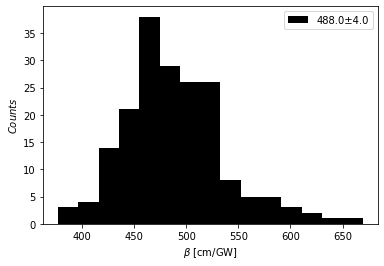

In [ ]:
beta_hist=[]
beta_min=[]
number=200 # Número de ajustes
#señal_ruido=ruido(T,cantidad_ruido)
for i in range(0,number):
  #EJEMPLO
  r1,r2= ajuste2(señal_ruido,focal,cantidad_ruido)
  if len(r1)>=1:
    beta_hist.append(r1[0])
    
error=str(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),0))
plt.hist(beta_hist,bins='fd',color='black',label=str(round(np.mean(beta_hist),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('$Counts$')
plt.legend()

 # ¿Qué tanto influye la cantidad de ruido en este método de ajuste en el calculo de $β$?
  
Al realizar el análisis anterior hemos utilizado un ruido particular, pero, ¿qué tanto influye el ruido en la señal en el β esperado? Para estudiar esto fijamos el ruido, generamos una señal experimental y realizamos un histograma con los β que se obtienen. Luego se repite lo anterior para otro ruido. Lo que se pretende es comparar que valor de β esperariamos obtener mediante este método si el ruido en la señal aumenta.
 

In [ ]:
beta_hist1=[]
number=200
cantidad_ruido1=[0.001,0.005,0.009] # Desviación estandar del ruido.
for j in cantidad_ruido1 :
  beta_hist=[]
  señal_ruido=ruido(T,j) # Generamos la señal con el ruido j  
  for i in range(0,number):
    b1,e1= ajuste2(señal_ruido,focal,j)
    if len(b1)>=1:
      beta_hist.append(b1[0])
  beta_hist1.append(beta_hist)

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


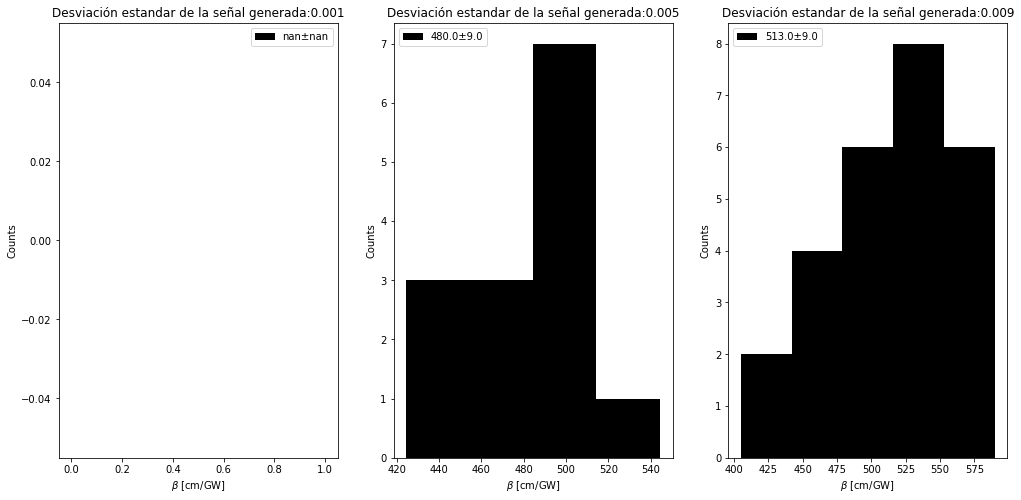

In [ ]:
f=plt.figure(figsize=(17,8))

plt.subplot(1,3,1)
error=str(round(np.std(beta_hist1[0],ddof=1)/np.sqrt(len(beta_hist1[0])),0))
plt.hist(beta_hist1[0],bins='fd',color='black',label=str(round(np.mean(beta_hist1[0]),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('Counts')
plt.title('Desviación estandar de la señal generada:'+str(cantidad_ruido1[0]))
plt.legend()


plt.subplot(1,3,2)
error=str(round(np.std(beta_hist1[1],ddof=1)/np.sqrt(len(beta_hist1[1])),0))
plt.hist(beta_hist1[1],bins='fd',color='black',label=str(round(np.mean(beta_hist1[1]),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('Counts')
plt.title('Desviación estandar de la señal generada:'+str(cantidad_ruido1[1]))
plt.legend()


plt.subplot(1,3,3)
error=str(round(np.std(beta_hist1[2],ddof=1)/np.sqrt(len(beta_hist1[2])),0))
plt.hist(beta_hist1[2],bins='fd',color='black',label=str(round(np.mean(beta_hist1[2]),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('Counts')
plt.title('Desviación estandar de la señal generada:'+str(cantidad_ruido1[2]))
plt.legend()


# Estudiando otras metricas.

Hasta el momento hemos hecho una comparación entre dos tecnicas de ajuste, una correspondiente a un ajuste directo y la otra mediante el protocolo, ambas incluyen la misma metrica para cuantificar la calidad del ajuste. En este caso hemos evidenciado que la tecnica directa puede variar mucho dependiendo del ruido de la señal, incluso en casos cuando uno tiene certeza que el ajuste es muy bueno, la otra tecnica sigue asegurando la obtención de un mejor β (esta afirmación en realidad no se ha probado para todos los casos, ver Ejemplo1, Ejemplo2, Ejemplo3). Lo que queda ahora por investigar es si es posible encontrar una metrica que permita obtener mejores valores de β e incluso que sea más sensible al ruido, ¿qué metrica sería la más adecuada? en general existen muchos criterios de ajuste, por ejemplo:

* Mean Error
* Mean Absolute Error 
* Root Mean Square Error 
* Normalized Root Mean Square Error 
* Pearson product-moment correlation coefficient 
* Coefficient of Determination 
* Index of Agreement 
* Modified Index of Agreement 
* Relative Index of Agreement 
* Ratio of Standard Deviations 
* Nash-sutcliffe Efficiency 
* Modified Nash-sutcliffe Efficiency 
* Relative Nash-sutcliffe Efficiency 
* Kling Gupta Efficiency 
* Deviation of gain 
* Standard deviation of residual 
* Kolmogorov-Smir


# A continuación programamos algunas metricas modificando la función ajuste2.

Particularmente se trabaja con dos:

$$\chi^{2}$$

$$(Min(y_i)-Min(y(x_i))^{2}$$

$$Metric=\chi^{2}+(Min(y_i)-Min(y(x_i))^{2}$$

# Metrica de $\chi^{2}$ programada directamente.



In [5]:
# -*- coding: utf-8 -*-
#Función de Ajuste 
def ajuste3(T_ruido,focal,ruido,metric): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  datos = T_ruido
  Best=[]
  ECMs = [] # creates metric list
  N = int(df.loc['N']['Valor']) #number of terms in the sum of the theoretical formula
  NN =int(df.loc['NN']['Valor']) # sample size
  beta0 = float(df.loc['beta0']['Valor']) # TPA seed in (m/W)

  nu=len(datos)-1 #Degrees of freedom

  L_c = float(df.loc['L_c']['Valor'])*float(df.loc['L_c']['Valor2']) # thickness in (m).
  L_e = float(df.loc['L_e']['Valor'])*float(df.loc['L_e']['Valor2']) # thickness error

  Pavg_c = float(df.loc['Pavg_c']['Valor'])*float(df.loc['Pavg_c']['Valor2']) # Average power in (W)
  Pavg_e = float(df.loc['Pavg_e']['Valor'])*float(df.loc['Pavg_e']['Valor2']) # Average power error

  Tp_c = float(df.loc['Tp_c']['Valor'])*float(df.loc['Tp_c']['Valor2']) # pulse width FWHM in (s)
  Tp_e = float(df.loc['Tp_e']['Valor'])*float(df.loc['Tp_e']['Valor2']) # pulse width error

  wl_c = float(df.loc['wl_c']['Valor'])*float(df.loc['wl_c']['Valor2']) #central wavelength in (m)
  wl_e = float(df.loc['wl_e']['Valor'])*float(df.loc['wl_e']['Valor2']) # central wavelength error

  D_c = float(df.loc['D_c']['Valor'])*float(df.loc['D_c']['Valor2']) # beam diameter in (m)
  D_e = float(df.loc['D_e']['Valor'])*float(df.loc['D_e']['Valor2']) # beam diameter error
  
  ds_c = float(df.loc['ds_c']['Valor'])*float(df.loc['ds_c']['Valor2']) # Distance EFTL-sample (m)
  ds_e = float(df.loc['ds_e']['Valor'])*float(df.loc['ds_e']['Valor2']) # distance EFTL-sample error

  Cf_c = float(df.loc['Cf_c']['Valor']) # beam correction coeff
  Cf_e = float(df.loc['Cf_e']['Valor'])

  alfa_c = float(df.loc['alfa_c']['Valor']) # linear absorption in (1/m) 
  alfa_e = float(df.loc['alfa_e']['Valor'])

  R_c = float(df.loc['R_c']['Valor']) # reflection percentage 
  R_e = float(df.loc['R_e']['Valor'])

  freq_c = float(df.loc['freq_c']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
  freq_e = float(df.loc['freq_e']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
     
  for ii in range(NN):
      

      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L_c,L_e,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg_c,Pavg_e,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp_c,Tp_e,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl_c,wl_e,1) #central wavelength in (m)
      D_f = np.random.normal(D_c,D_e,1) # beam diameter in (m)
      ds_f = np.random.normal(ds_c,ds_e,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf_c,Cf_e,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa_c,alfa_e,1)) #linear absorption (1/m)
      R_f = np.random.normal(R_c,R_e,1) # Reflectance
      freq_f = np.random.normal(freq_c,freq_e,1) # Reflectance
      ########################
      # Función ajustar
      def fscanTH(focal,beta):

        Leff = (1. - np.exp(-alfa*L_f))/alfa_f # Effective thickness
        w0 = 2.0*wl_f*focal*Cf_f/(np.pi*D_f) # beam waist
        z0 = np.pi*w0**2/wl_f # Rayleigh range
        w = w0*np.sqrt(1 + ((ds_f - focal)/z0)**2) # Beam radius
        I0 = 4*np.sqrt(np.log(2))*Pavg_f/(Tp_f*freq_f*np.pi**1.5*w**2) # Peak intensity at sample
        B = beta*(1.0 - R)*I0*Leff
        # Transmitance
        T=1-1/(2*np.sqrt(2))*beta*(1-R_f)*I0*Leff/(1+((ds_f-focal)/z0)**2)
        #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
            ##  for i in range(len(B))]
        return T
  # fscan TPA theoretical function with one variable parameter
      '''
      def fscanTH(focal,beta):
          Leff = (1. - np.exp(-alfa_f*L_f))/alfa_f # Effective thickness
          w0 = 2.0*wl_f*focal*Cf_f/(np.pi*D_f) # beam waist
          z0 = np.pi*w0**2/wl_f # Rayleigh range
          w = w0*np.sqrt(1 + ((ds_f - focal)/z0)**2) # Beam radius
          I0 = 2*np.log(1 + np.sqrt(2))*Pavg_f/(Tp_f*freq_f*np.pi*w**2) # Peak intensity at sample
          B = beta*(1.0 - R_f)*I0*Leff
      # Transmitance
          T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
                for i in range(len(B))]
          
          return np.array(T)
      '''
      def metrica(beta):
            ########################global focal,datos
        T = fscanTH(focal,beta) # Transmitance
        if metric=='chi':
          dist =  sum((T[i]-datos[i])**2/ruido**2  for i in range(len(T))) # values distance
        if metric=='min':
          dmin_E=np.amin(datos)
          dmin_T=np.amin(T)
          dist = (dmin_E-dmin_T)**2 # values distance

        if metric=='max':
          dmin_E=np.max(datos)
          dmin_T=np.max(T)
          dist = (dmin_E-dmin_T)**2 # values distance

        if metric=='chi_min':
          dmin_E=np.amin(datos)
          dmin_T=np.amin(T)
          dist = sum((T[i]-datos[i])**2 for i in range(len(T)))+(dmin_E-dmin_T)**2 # values distance
        return dist

      # Fitting rutine

      betaopt = fmin(metrica, beta0, full_output=False, xtol=1e-8, disp=False)
      ECM=metrica(betaopt[0])# Metric \chi_{min}^2
      Prob= 1 - stats.chi2.cdf(ECM, nu) ## P(\chi^2_min,\nu)
  
      ########################
      ECMs = np.append(ECMs,ECM) # Metric values vector
      
      # According to Ifan Hughes when this condition is satisfied 
      # the null hypothesis is generally not rejected

      if metric=='chi':

      
        if (nu-2*np.sqrt(2*nu))<=ECM<=(nu+2*np.sqrt(2*nu)): 
          
            miro = np.concatenate((np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f,
                                  D_f,ds_f,Cf_f,alfa_f,R_f))
          
            Best = np.append(Best,miro)

      if metric=='chi_min':
        
        if (nu-2*np.sqrt(2*nu))<=ECM<=(nu+4*np.sqrt(4*nu)):

          miro = np.concatenate((np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f,
                                    D_f,ds_f,Cf_f,alfa_f,R_f))
        
          Best = np.append(Best,miro)
      

      if metric=='min':

        if ECM < 1e-4:

          miro = np.concatenate((np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f,
                                    D_f,ds_f,Cf_f,alfa_f,R_f))
        
          Best = np.append(Best,miro)

      if metric=='max':

        
          miro = np.concatenate((np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f,
                                    D_f,ds_f,Cf_f,alfa_f,R_f))
        
          Best = np.append(Best,miro)

  tamBest = int(len(Best)/11) # size of best-fit values vector
  
  Best = np.reshape(Best,(tamBest,11)) # Matrix where each row contains
  # The parameters of the fit in the following order
  # np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f, D_f,ds_f,Cf_f,alfa_f,R_f)
                                 
  ########################
  if len(Best[:,1])!=0:
  # Best values average TPA
      Best_avg = [np.average(Best[:,1])*1e11]# cm/GW
      error= [np.std(Best[:,1]*1e11 )/len(Best[:,1])] # Error estandar.
  else:
    Best_avg=[]
    error=[]
    
  return Best_avg, error

# 1) Metrica $\chi^{2}$
 
#Resultados.

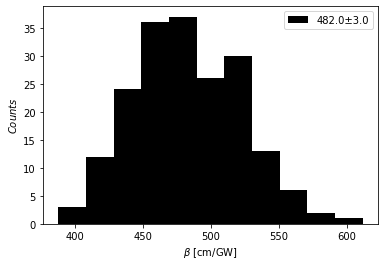

In [ ]:
dataa=np.loadtxt(os.getcwd()+'/Example11.txt')
corriente=dataa[:,0]
focal=focalcurr('opt2',corriente) #focal distance [m]
señal_ruido=dataa[:,1]
beta_hist=[]
number=200 # Número de ajustes
#señal_ruido=ruido(T,cantidad_ruido)
for i in range(0,number):
  #EJEMPLO
  r1,r2= ajuste3(señal_ruido,focal,0.03,'chi')
  if len(r1)>=1:
    beta_hist.append(r1[0])

error=str(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),0))
plt.hist(beta_hist,bins='fd',color='black',label=str(round(np.mean(beta_hist),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('$Counts$')
plt.legend()

# Metrica 2: Minimización de distancia entre minimos

# Resultados.

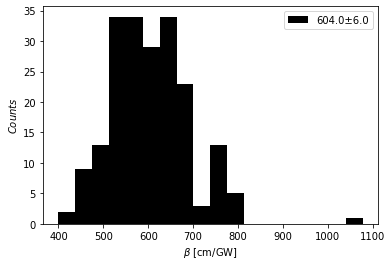

In [ ]:
beta_hist=[]
beta_min=[]
number=200 # Número de ajustes
#señal_ruido=ruido(T,cantidad_ruido)
for i in range(0,number):
  #EJEMPLO
  r1,r2= ajuste3(señal_ruido,focal,0.03,'min')
  if len(r1)>=1:
    beta_hist.append(r1[0])

error=str(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),0))
plt.hist(beta_hist,bins='fd',color='black',label=str(round(np.mean(beta_hist),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('$Counts$')
plt.legend()

# 3. Metrica donde se minimiza la distancia entre minimos mas $\chi^{2}$.

# Resultados.

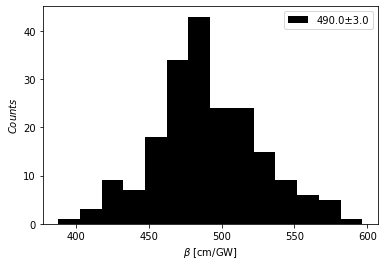

In [ ]:
beta_hist=[]
beta_min=[]
number=200 # Número de ajustes
#señal_ruido=ruido(T,cantidad_ruido)
for i in range(0,number):
  #EJEMPLO
  r1,r2= ajuste3(señal_ruido,focal,0.03,'chi_min')
  if len(r1)>=1:
    beta_hist.append(r1[0])

error=str(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),0))
plt.hist(beta_hist,bins='fd',color='black',label=str(round(np.mean(beta_hist),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('$Counts$')
plt.legend()

#  (Tarea) Se debe elegir un criterio de aceptación para las metricas donde de forma rigurosa se escoja los β

# Intento de ajuste de datos experimentales.

- Corrección de oscilaciones (sin muestra):
Dado que es de esperarse que para cualquier distancia focal se detecte aproximadamente un valor constante de voltaje, lo que se hace es medir el voltaje del láser en el tiempo para una potencia al final del experimento y asumir que el valor promedio en el tiempo es el que justamente se debería de obtener para cuando uno mida el valor del voltaje en función de la distancia focal. Esto último no ocurre en la práctica, por tanto, hacemos la corrección, se debe hacer la siguiente corrección:

$$V^{sin}_{corr}(f)=V^{sin}_{avg}-V^{sin}_{osc}(f)  \hspace{0.4cm}  (1)$$

Siendo $V^{sin}_{avg}$, $V^{sin}_{osc}(f)$, $V^{sin}_{corr}(f)$ el valor de voltaje promedio en el tiempo, el valor del voltaje consecuencia del error sistemático de la lente para una distancia focal f y la corrección al valor real $V_{corr}(f)$ respectivamente. En el caso de hacer f-scan sin muestra se estaría midiendo $V^{sin}_{sis}(f)$ lo que hace, por tanto, conveniente encontrar el valor $V^{sin}_{avg}$ conociendo ya $V_{corr}(f)$.

- Corrección de oscilaciones (con muestra): Ciertamente el valor de la corrección para cuando haya muestra sera diferente por dos razones: la primera es que en analogia a lo que se hizo anteriormente donde se asume que $V^{sin}_{avg}$ $\forall f$ no es valido en este caso, pues dependiendo del foco, la potencia se atenuara de forma diferente. Por tanto, se debe replantear (1) como:

$$V^{con}_{corr}(f)=V^{con}_{avg}(f)-V^{con}_{osc}(f)  \hspace{0.4cm}  (2)$$

Donde las variables mantienen su definición anterior pero con muestra. Para relacionar las variables de la ecuación (1) con (2), se asumira que fijado la distancia focal la muestra solo atenua la señal de las variables de (1) pero no modifica sus oscilaciones, esto es,

$$V^{con}_{osc}(f)=\alpha (f) V^{sin}_{osc} ⇒ \alpha (f)=\frac{V^{con}_{osc}(f)}{V^{sin}_{osc}}  \hspace{0.4cm}  (3) $$

y por tanto 

$$V^{con}_{avg}(f)=\alpha (f) V^{sin}_{avg}   \hspace{0.4cm}  (4)$$








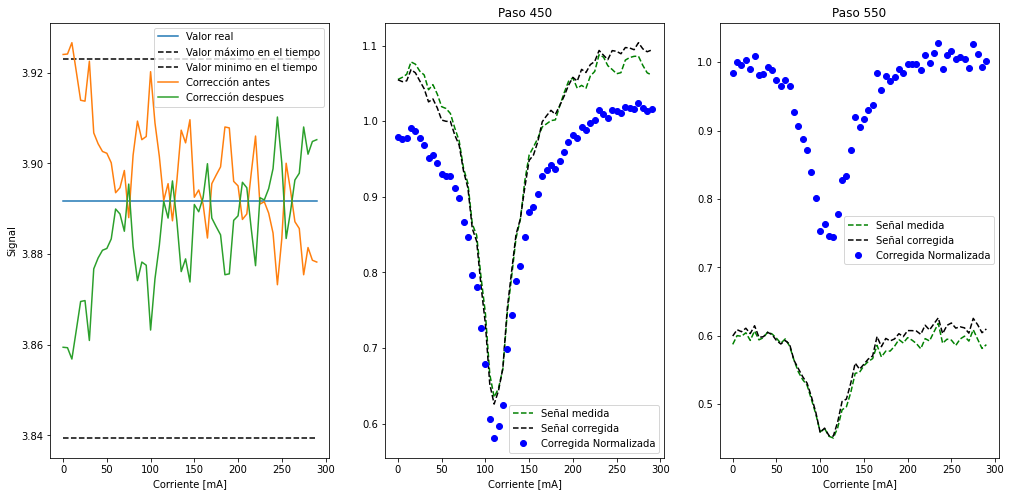

In [6]:
# Se cargan los datos:

path=os.getcwd()+'/Oscilaciones'
datosprom=[] #Focal distances (mA)

# Señal en el tiempo 450
datos1=np.loadtxt(path+"/ev_señal3.txt")
datos2=np.loadtxt(path+"/ev_señal4.txt")
datos3=np.loadtxt(path+"/ev_señal5.txt")
# Señal en el tiempo 550
datos4=np.loadtxt(path+"/ev_señal6.txt")
#Promedio a 450
avg=np.mean(np.concatenate((datos1[:,1],datos2[:,1],datos3[:,1])))
#Promedio a 550
avg2=np.mean(datos4[:,1])
#F-scan sin, con , sin muestra a 450
datos1f=np.loadtxt(path+'/F-scan_100mm_3.txt')
datos2f=np.loadtxt(path+'/F-scan_100mm_5.txt')
datose=np.loadtxt(path+'/F-scan_100mm_4.txt')
#F-scan sin, con , sin muestra a 550
datos_1f=np.loadtxt(path+'/F-scan_100mm_6.txt')
datos_2f=np.loadtxt(path+'/F-scan_100mm_8.txt')
datos_e=np.loadtxt(path+'/F-scan_100mm_7.txt')
#Corrección sin  muestra 450
corr=avg-(datos1f[:,1]+datos2f[:,1])/2
#Corrección sin muestra 550
#corr1=avg2-(datos_1f[:,1]+datos_2f[:,1])/2

f=plt.figure(figsize=(17,8))  

plt.subplot(1,3,1)
#plt.plot(datos1f[:,0],datos1f[:,1],label='Antes')
#plt.plot(datos2f[:,0],datos2f[:,1],label='Despues')
plt.title("")
plt.plot(datos1f[:,0],avg*np.ones(len(datos1f[:,1])),label='Valor real')
plt.plot(datos1f[:,0],(np.max(datos2[:,1]))*np.ones(len(datos1f[:,1])),'--k',label='Valor máximo en el tiempo')
plt.plot(datos1f[:,0],(np.min(datos1[:,1]))*np.ones(len(datos1f[:,1])),'--k',label='Valor minimo en el tiempo')
#plt.plot(datos1f[:,0],(datos1f[:,1]+datos2f[:,1])/2+corr,label='Promedio f')
plt.plot(datos1f[:,0],datos1f[:,1]+corr,label='Corrección antes')
plt.plot(datos1f[:,0],datos2f[:,1]+corr,label='Corrección despues')
plt.xlabel('Corriente [mA]')
plt.ylabel('Signal')
plt.legend()


plt.subplot(1,3,2)
alpha=datose[:,1]/datos1f[:,1]
real=alpha*avg
Trans1= normalizacion(real,df.loc['Normalizacion']['Valor'])
#plt.plot(datose[:,0],alpha,label='F-scan con muestra')
plt.plot(datose[:,0],datose[:,1],'--g',label='Señal medida')
plt.plot(datose[:,0],real,'--k',label='Señal corregida')
plt.plot(datose[:,0],Trans1,'bo',label='Corregida Normalizada')
plt.xlabel('Corriente [mA]')
plt.title("Paso 450")
plt.legend()

plt.subplot(1,3,3)
alpha=datos_e[:,1]/datos_1f[:,1]
real2=alpha*avg2
Trans2= normalizacion(real2,df.loc['Normalizacion']['Valor'])
plt.title("Paso 550")
#plt.plot(datose[:,0],alpha,label='F-scan con muestra')
plt.plot(datos_e[:,0],datos_e[:,1],'--g',label='Señal medida')
plt.plot(datos_e[:,0],real2,'--k',label='Señal corregida')
plt.xlabel('Corriente [mA]')
plt.plot(datos_e[:,0],Trans2,'bo',label='Corregida Normalizada')
plt.legend()

# Ajuste

Para realizar el ajuste experimental se necesita de la distancia muestra-lente y la potencia usada. Para este ultimo recordemos que habíamos hecho una calibración, de acuerdo a lo siguiente:

$$ P_{avg}= P_{max} 10^{-m \theta}$$

Donde $m=0.0148$ $degree^{-1}$ y $P_{max}=95$ $mW$, por otro lado, recordar que la conversión a grados es dada por la expresión $360*paso/2048$. Finalmente, antes de realizar el ajuste debemos cuantificar el error estandar de los datos para poder utilizar el método. Este se calculara apartir de los datos que había tomado donde se estudio el comportamiento del laser en el tiempo, esto es:

In [18]:
Pmax=95e-3 # Potencia máxima.
m=0.0148 
paso=450
focal=np.sort(focalcurr('opt2',datose[:,0])) #focal distance [m])
def conv_P(paso):
    return Pmax*10**(-m*360*paso/2048)



# Ajuste directo

L = float(df.loc['L_c']['Valor'])*float(df.loc['L_c']['Valor2']) # thickness in (m).
Pavg = conv_P(paso)
Tp= float(df.loc['Tp_c']['Valor'])*float(df.loc['Tp_c']['Valor2']) # pulse width FWHM in (s)
wl = float(df.loc['wl_c']['Valor'])*float(df.loc['wl_c']['Valor2']) #central wavelength in (m)
D = float(df.loc['D_c']['Valor'])*float(df.loc['D_c']['Valor2']) # beam diameter in (m)
ds=focal[np.where(Trans1 == Trans1.min())[0][0]]
Cf = float(df.loc['Cf_c']['Valor']) # beam correction coeff
alfa= float(df.loc['alfa_c']['Valor']) # linear absorption in (1/m) 
R = float(df.loc['R_c']['Valor']) # reflection percentage 
freq = float(df.loc['freq_c']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
df.loc['Pavg_c','Valor']=str(Pavg)  #Nuevo parametro
df.loc['ds_c','Valor']=str(ds)  #Nuevo parametro
#intento_ajuste=fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq,N)

def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

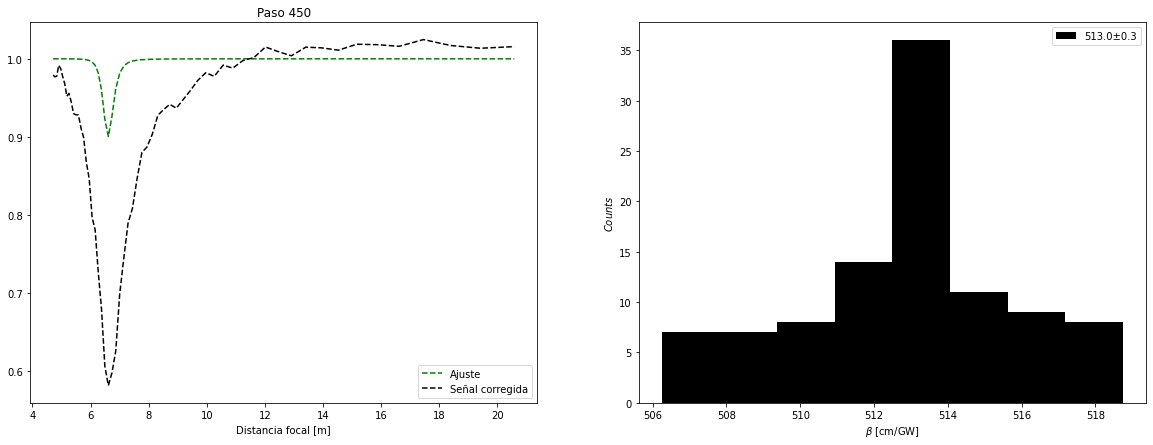

In [20]:
f=plt.figure(figsize=(20,7))

ruido1=np.std(datos4[:,1],ddof=1)

beta_hist=[]
number=100 # Número de ajustes
#señal_ruido=ruido(T,cantidad_ruido)
for i in range(0,number):
  #EJEMPLO
  r1,r2= ajuste3(Trans1,focal,ruido1,'max')
  if len(r1)>=1:
    beta_hist.append(r1[0])

T=fscanTH2(focal,beta*1e-11,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq) 
plt.subplot(121)
beta=np.mean(beta_hist)
plt.plot(focal*100,T,'--g',label='Ajuste')
plt.plot(focal*100,Trans1,'--k',label='Señal corregida')
plt.xlabel('Distancia focal [m]')
plt.title("Paso 450")
plt.legend()


plt.subplot(122)
error=str(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),1))
plt.hist(beta_hist,bins='fd',color='black',label=str(round(np.mean(beta_hist),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('$Counts$')
plt.legend()




In [15]:
beta

512.7375

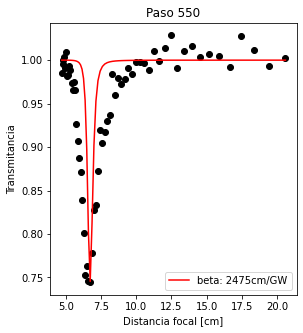

In [ ]:
Pmax=95e-3 # Potencia máxima.
m=0.0148 
paso=550
focal=np.sort(focalcurr('opt2',datos_e[:,0])) #focal distance [m])
Trans= normalizacion(Trans2,df.loc['Normalizacion']['Valor'])

def conv_P(paso):
    return Pmax*10**(-m*360*paso/2048)

f=plt.figure(figsize=(15,5))

# Ajuste directo

L = float(df.loc['L_c']['Valor'])*float(df.loc['L_c']['Valor2']) # thickness in (m).
Pavg = conv_P(paso)
Tp= float(df.loc['Tp_c']['Valor'])*float(df.loc['Tp_c']['Valor2']) # pulse width FWHM in (s)
wl = float(df.loc['wl_c']['Valor'])*float(df.loc['wl_c']['Valor2']) #central wavelength in (m)
D = float(df.loc['D_c']['Valor'])*float(df.loc['D_c']['Valor2']) # beam diameter in (m)
ds=focal[np.where(Trans == Trans.min())[0][0]]
Cf = float(df.loc['Cf_c']['Valor']) # beam correction coeff
alfa= float(df.loc['alfa_c']['Valor']) # linear absorption in (1/m) 
R = float(df.loc['R_c']['Valor']) # reflection percentage 
freq = float(df.loc['freq_c']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
N=2
df.loc['Pavg_c','Valor']=str(Pavg)  #Nuevo parametro
df.loc['ds_c','Valor']=str(ds)  #Nuevo parametro
#intento_ajuste=fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq,N)

# Función ajustar
def fscanTH(focal,beta):

  Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
  w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
  z0 = np.pi*w0**2/wl # Rayleigh range
  w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
  I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
  B = beta*(1.0 - R)*I0*Leff
  # Transmitance
  T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
  #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
      ##  for i in range(len(B))]
  return T

ruido1=np.std(datos4[:,1],ddof=1)/np.sqrt(len(datos4[:,1]))
plt.subplot(1,2,1)
beta_hist=[]
number=100 # Número de ajustes
#señal_ruido=ruido(T,cantidad_ruido)
for i in range(0,number):
  #EJEMPLO
  r1,r2= ajuste3(Trans,focal,ruido1,'chi_min')
  if len(r1)>=1:
    beta_hist.append(r1[0])

error=str(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),0))
plt.hist(beta_hist,bins='fd',color='black',label=str(round(np.mean(beta_hist),0))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('$Counts$')
plt.legend()


plt.subplot(1,2,2)
plt.plot(focal*100,Trans,'ko',label='experimental')
plt.plot(focal*100,fscanTH(focal,np.mean(beta_hist)*1e-11),'-r',label='beta: '+str(round(np.mean(beta_hist),0))+' cm/GW')
plt.xlabel('Distancia focal [cm]')
plt.ylabel('Transmitancia')
plt.title('Paso 450')
plt.legend()



# Parte 2.

# Sensibilidad de la obtención de β bajo la incertidumbre en el valor de uno de los parametros de ajuste.

$$f=f(x,\beta;\{L, P_{avg}, T_{p}, w_{l}, D, ds, C_f, \alpha, R, \nu)$$

Donde x es la variable independiente (distancia focal, potencia, ...) y $\beta$ es el parámetro a encontrar del ajuste (en nuetro caso, el coeficiente de absorción de dos fotones), por otro lado, $\{L, P_{av}, T_{p}, w_{l}, D, ds, Cf, \alpha, R, \nu \}$ representan parámetros que en principio son 'conocidos del experimento' y que se asumen representan la media de una distribución Gaussiana. Una pregunta natural que surge es si tener incertidumbre en el conocimiento de alguno de estos parametros afecta la obtención de β.



# Variar parametros.






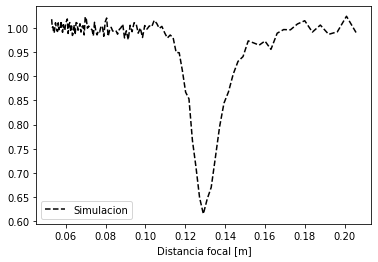

In [ ]:
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 130e-3# Distance EFTL-sample (m)
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) (CdS@790 -2.64e-11, ZnSe@790 4.7720, CdSe@790 369.8)alfa_e = float(df.loc['alfa_e']['Valor'])*float(df.loc['alfa_e']['Valor2'])
R =0.33 # reflection percentage (CdS@790 = 0.15670, ZnSe@790 0.18164)
freq = 11e3 #Frecuencia en HZ
corriente=np.arange(0,250,2)
focal=focalcurr('opt2',corriente) #focal distance [m]
T=fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)  #Señal simulada
cantidad_ruido=0.01
señal_ruido=ruido(T,cantidad_ruido)
plt.plot(focal,señal_ruido,'--k',label='Simulacion')
plt.xlabel('Distancia focal [m]')
plt.legend()

In [ ]:
def variar(par,error_rel,metrica,N=10 ):
    '''
    Función que fijada una curva llamada señal_ruido permite estudiar 
    el cambio en el TPA variante un parametro

    Parametros
    -----------
    par: String
      Parametro a modificar ingresado como cadena: {L_c, Pavg_c,  Tp_c, wl_c , D_c, ds_c, Cf_c, alpha_c, R_c}
    error_rel: float
      Error relativo donde se quiere estudiar la variación de par:
        (parametro-error_rel*parametro,parametro+error_rel*parametro)
    metrica: String
      Metrica con la cual se realizara el ajuste: 'chi', 'min', 'chi_min'
    N: float
      Número de puntos en el rango de estudio.


    '''

    df = pd.read_csv('Parametros_fscan.txt', delimiter = "\t",index_col=0)
    parametro=float(df.loc[par,'Valor'])
    rango=np.linspace(parametro-error_rel*parametro,parametro+error_rel*parametro,N)
    rango_new=[]
    betas2=[] # Beta metodo 2
    errorb2=[] # error Beta metodo 2
    
    for j in range(len(rango)):
        
        df.loc[par,'Valor']=str(rango[j])  #Nuevo parametro
        df.loc[par.replace('c','e'),'Valor']=str(0) # Error en el nuevo parametro
        number=50 # Número de ajustes
        beta_hist=[]
        for i in range(0,number):
            #EJEMPLO
            r1,r2= ajuste3(señal_ruido,focal,cantidad_ruido,metrica)
            if len(r1)>0:
              beta_hist.append(r1[0])

        if len(r1)>0:
            error=np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist))
            betas2.append(r1[0])
            rango_new.append(rango[j])
            errorb2.append(error)

    betas2=np.array(betas2)
    errorb2=np.array(errorb2)
    rango_new=np.array(rango_new)
        
    return betas2,errorb2, rango_new, parametro

    

In [ ]:
N=10 
er_rel=0.3
parametroo='D_c' #{L_c, Pavg_c,  Tp_c, wl_c , D_c, ds_c, Cf_c, alpha_c, R_c}
betas2,errorb2,rango,p =variar(parametroo,er_rel,'chi_min',N)




In [ ]:
#Agregando barras de error al error relativo.
x1=abs((rango[0:int(N/2)]-p)/p)

erb1=abs((betas2[0:int(N/2)]-beta*1e2))/(beta*1e2) #  error relativo del beta.

x2=abs((rango[int(N/2):int(N)+1]-p)/p) 

erb2=abs((betas2[int(N/2):int(N)+1]-beta*1e2))/(beta*1e2) # error relativo del beta.

ee1l=abs((betas2[0:int(N/2)]-errorb2[0:int(N/2)]-beta*1e2))/(beta*1e2) # Error asociado al error relativo del beta. 1

ee1u=abs((betas2[0:int(N/2)]+errorb2[0:int(N/2)]-beta*1e2))/(beta*1e2) # Error asociado al error relativo del beta. 1

eee1=np.array([abs(ee1l-erb1),abs(ee1u+erb1)])

ee2l=abs((betas2[int(N/2):int(N)+1]-errorb2[int(N/2):int(N)+1]-beta*1e2))/(beta*1e2) # Error asociado al error relativo del beta

ee2u=abs((betas2[int(N/2):int(N)+1]+errorb2[int(N/2):int(N)+1]-beta*1e2))/(beta*1e2) # Error asociado al error relativo del beta 2.

eee2=np.array([abs(ee2l-erb2),abs(ee2u+erb2)])

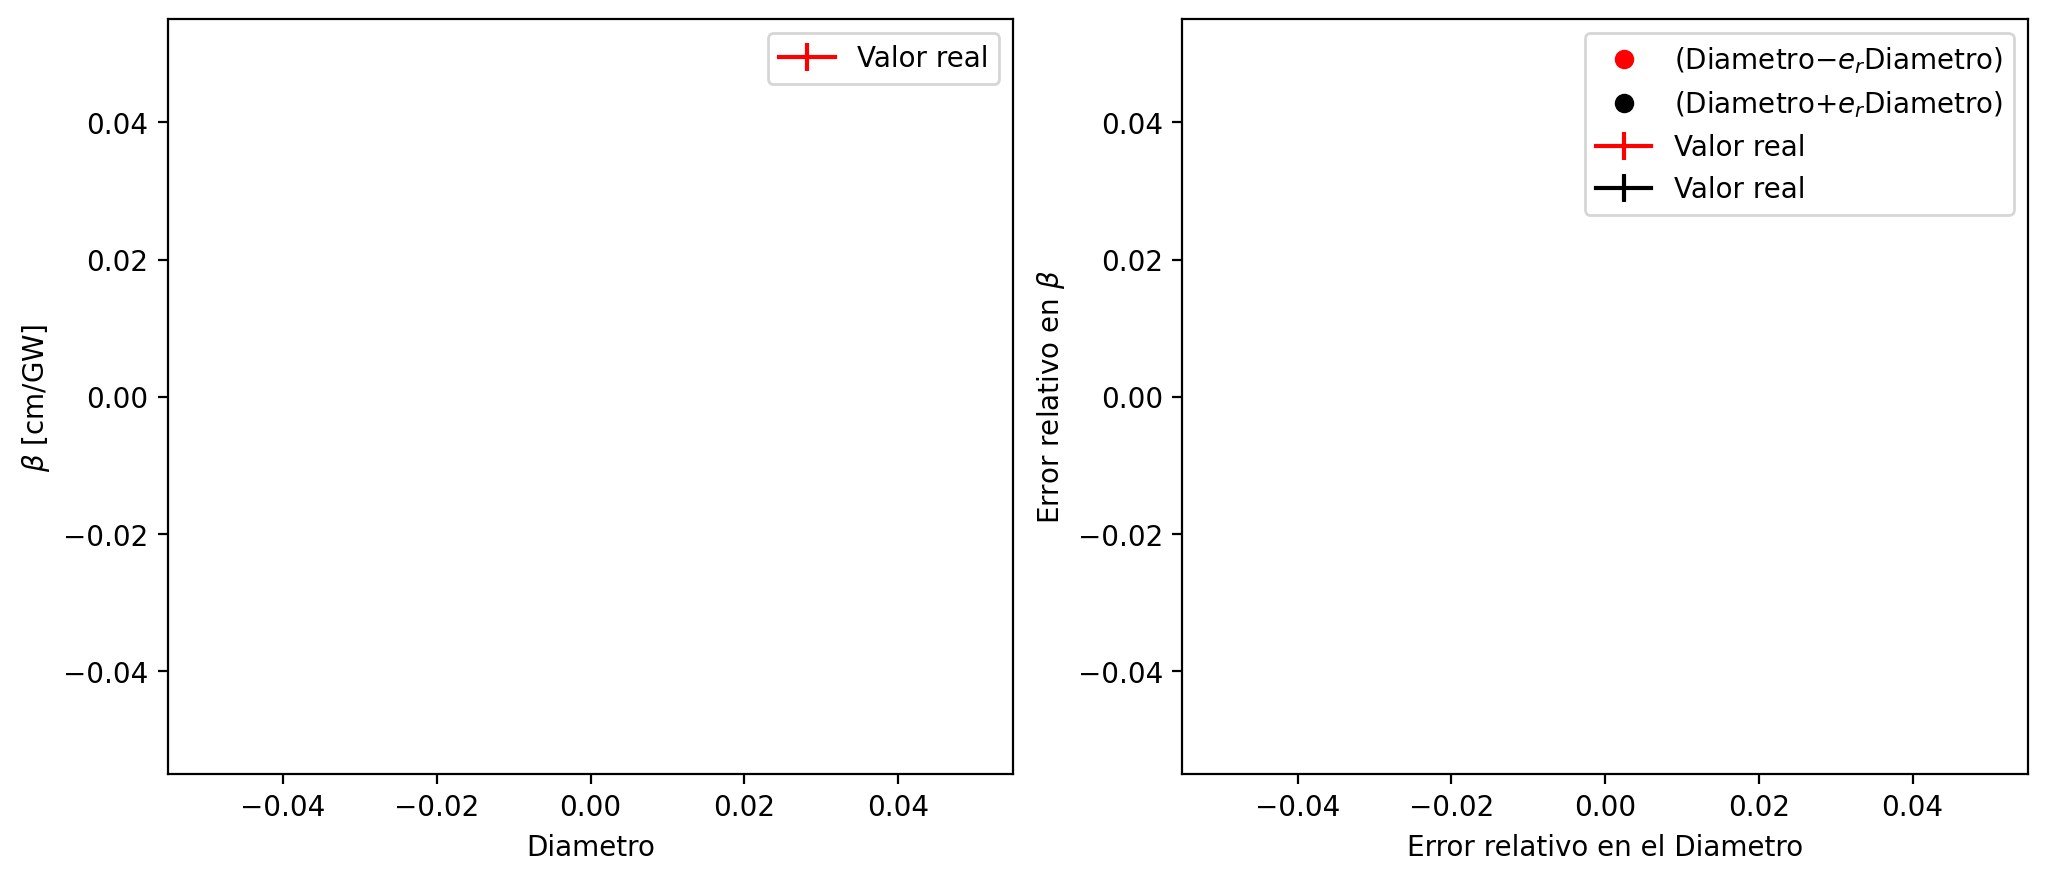

In [ ]:
nombres=["Longitud","Potencia promedio","Ancho temporal","Longitud de onda","Diametro","Distancia muestra-lente","Coeficiente","Coeficiente de absorcion",'Coeficiente de reflexion']
nombre1= 4 #["Longitud","Potencia promedio","Ancho temporal","Longitud de onda","Diametro","Distancia muestra-lente","Coeficiente","Coeficiente de absorcion",'Coeficiente de reflexion']
nombre2=4 #{L, P_{av}, T_{p}, w_{l}, D, ds, Cf, \alpha, R\}
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 40}

#plt.rcParams['figure.figsize'] = (15, 40)
f = plt.figure(figsize=(12, 5),dpi=200)


plt.subplot( 1,2, 1)
plt.plot(rango,beta*1e11*np.ones(len(rango)),'k--')
plt.plot(rango,betas2,color='k',marker='o')
#plt.plot(rango,yy,color='g',marker='o',label='Ajuste: $R^{2}$='+str(round(r_value**2,4)))
plt.errorbar(rango,betas2,yerr=errorb2,color='r',label='Valor real')
plt.ylabel(r"$\beta$ [cm/GW]",size=10)
plt.xlabel('Diametro [mm]')
plt.legend()
plt.xlabel(nombres[nombre1])
    
plt.subplot(1,2, 2)
plt.plot(x1,erb1,'ro',label='('+nombres[nombre2]+'$-e_{r}$'+nombres[nombre2]+')')
plt.errorbar(x1,erb1,yerr=eee1,color='r',label='Valor real')
plt.plot(x2,erb2,'ko',label='('+nombres[nombre2]+'$+e_{r}$'+nombres[nombre2]+')')
plt.errorbar(x2,erb2,yerr=eee2,color='k',label='Valor real')


plt.ylabel("Error relativo en " r"$\beta$")
plt.xlabel("Error relativo en el "+nombres[nombre1])
plt.legend()




# Potencia.

In [ ]:
N=10 
er_rel=0.3
sigmas=0.001
parametroo='Pavg_c' #{L_c, Pavg_c,  Tp_c, wl_c , D_c, ds_c, Cf_c, alpha_c, R_c}
betas2,errorb2,rango,p =variar2(parametroo,er_rel,sigmas,N)

#Ajuste \beta vs Diametro
slope, intercept, r_value, p_value, std_err = stats.linregress(rango,betas2)
yy=slope*rango+intercept


In [ ]:
#Agregando barras de error al error relativo.
x1=abs((rango[0:int(N/2)]-p)/p)

erb1=abs((betas2[0:int(N/2)]-beta*1e2))/(beta*1e2) #  error relativo del beta.

x2=abs((rango[int(N/2):int(N)+1]-p)/p) 

erb2=abs((betas2[int(N/2):int(N)+1]-beta*1e2))/(beta*1e2) # error relativo del beta.

ee1l=abs((betas2[0:int(N/2)]-errorb2[0:int(N/2)]-beta*1e2))/(beta*1e2) # Error asociado al error relativo del beta. 1

ee1u=abs((betas2[0:int(N/2)]+errorb2[0:int(N/2)]-beta*1e2))/(beta*1e2) # Error asociado al error relativo del beta. 1

eee1=np.array([abs(ee1l-erb1),abs(ee1u+erb1)])

ee2l=abs((betas2[int(N/2):int(N)+1]-errorb2[int(N/2):int(N)+1]-beta*1e2))/(beta*1e2) # Error asociado al error relativo del beta

ee2u=abs((betas2[int(N/2):int(N)+1]+errorb2[int(N/2):int(N)+1]-beta*1e2))/(beta*1e2) # Error asociado al error relativo del beta 2.

eee2=np.array([abs(ee2l-erb2),abs(ee2u+erb2)])


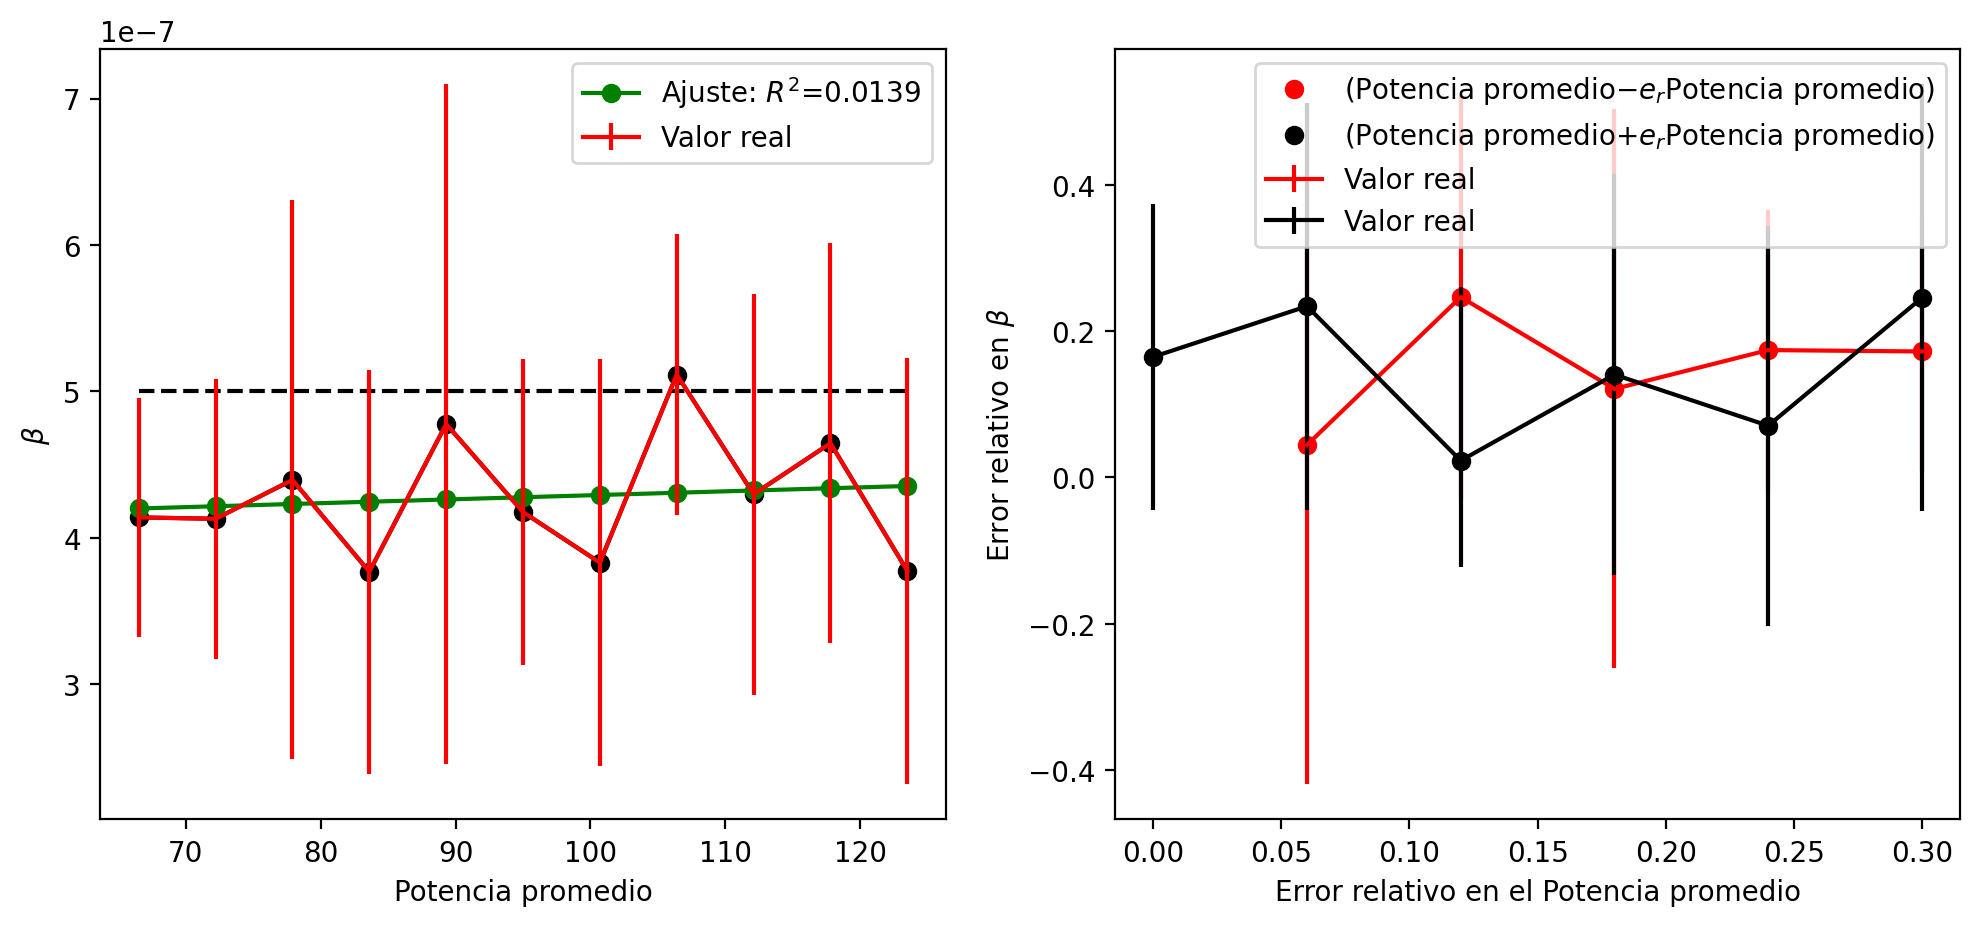

In [ ]:
nombres=["Longitud","Potencia promedio","Ancho temporal","Longitud de onda","Diametro","Distancia muestra-lente","Coeficiente","Coeficiente de absorcion",'Coeficiente de reflexion']
nombre1= 1 #["Longitud","Potencia promedio","Ancho temporal","Longitud de onda","Diametro","Distancia muestra-lente","Coeficiente","Coeficiente de absorcion",'Coeficiente de reflexion']
nombre2=1 #{L, P_{av}, T_{p}, w_{l}, D, ds, Cf, \alpha, R\}
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 40}

#plt.rcParams['figure.figsize'] = (15, 40)
f = plt.figure(figsize=(12, 5),dpi=200)


plt.subplot( 1,2, 1)
plt.plot(rango,np.ones(len(rango))*beta*1e2,'k--')
plt.plot(rango,betas2,color='k',marker='o')
plt.plot(rango,yy,color='g',marker='o',label='Ajuste: $R^{2}$='+str(round(r_value**2,4)))
plt.errorbar(rango,betas2,yerr=errorb2,color='r',label='Valor real')
plt.ylabel(r"$\beta$",size=10)
plt.legend()
plt.xlabel(nombres[nombre1])
    
plt.subplot(1,2, 2)
plt.plot(x1,erb1,'ro',label='('+nombres[nombre2]+'$-e_{r}$'+nombres[nombre2]+')')
plt.errorbar(x1,erb1,yerr=eee1,color='r',label='Valor real')
plt.plot(x2,erb2,'ko',label='('+nombres[nombre2]+'$+e_{r}$'+nombres[nombre2]+')')
plt.errorbar(x2,erb2,yerr=eee2,color='k',label='Valor real')


plt.ylabel("Error relativo en " r"$\beta$")
plt.xlabel("Error relativo en el "+nombres[nombre1])
plt.legend()




# Histogramas.

Para dar una conclusión precisa del $\beta$ se deben realizar histogramas.

In [ ]:
######################## PARAMETROS EXPERIMENTALES.
df = pd.read_csv('Parametros_fscan.txt', delimiter = "\t",index_col=0)
corriente=np.arange(0,202,2) #Current [mA]
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=focalcurr('opt2',corriente) #focal distance [m]
N = 11 #number of terms in the sum of the theoretical formula
#NN = int(df.loc['NN']['Valor']) # sample size
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 130e-3# Distance EFTL-sample (m)
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) (CdS@790 -2.64e-11, ZnSe@790 4.7720, CdSe@790 369.8)alfa_e = float(df.loc['alfa_e']['Valor'])*float(df.loc['alfa_e']['Valor2'])
R =0.33 # reflection percentage (CdS@790 = 0.15670, ZnSe@790 0.18164)
freq = 11e3 #Frecuencia en HZ
########################
path=os.getcwd()+'\\Datos\data_simulada.txt' # Ruta de archivo donde se guardaran los datos simulados
T=fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,N)  #Señal simulada
cantidad_ruido=0.001 # Desviación estandar del ruido.
data = np.column_stack([corriente, ruido(T,cantidad_ruido)]) # corriente, señal simulada con ruido
np.savetxt(path, data, fmt=['%d','%.8f'])    
#EJEMPLO
bet_hist=[]
for i in range(100):
    b,ee,p,betas= ajuste2(cantidad_ruido)
    bet_hist.append(b[0])


(array([ 2.,  1.,  6., 12., 17., 32., 10., 11.,  5.,  2.,  0.,  1.,  0.,
         0.,  1.]),
 array([2.09796801e-07, 2.46129503e-07, 2.82462206e-07, 3.18794909e-07,
        3.55127612e-07, 3.91460315e-07, 4.27793018e-07, 4.64125720e-07,
        5.00458423e-07, 5.36791126e-07, 5.73123829e-07, 6.09456532e-07,
        6.45789235e-07, 6.82121938e-07, 7.18454640e-07, 7.54787343e-07]),
 <BarContainer object of 15 artists>)

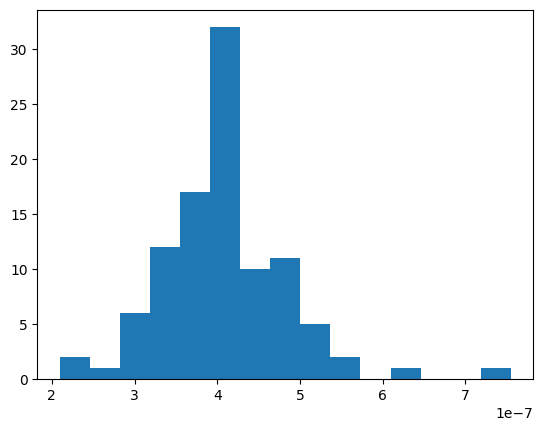

In [ ]:
plt.hist(bet_hist,bins='fd')
#plt.xlabel('$\beta$')
#plt.ylabel('$Counts$')

In [ ]:
######################## PARAMETROS EXPERIMENTALES.
df = pd.read_csv('Parametros_fscan.txt', delimiter = "\t",index_col=0)
corriente=np.arange(0,202,2) #Current [mA]
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=focalcurr('opt2',corriente) #focal distance [m]
N = 11 #number of terms in the sum of the theoretical formula
#NN = int(df.loc['NN']['Valor']) # sample size
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 130e-3# Distance EFTL-sample (m)
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) (CdS@790 -2.64e-11, ZnSe@790 4.7720, CdSe@790 369.8)alfa_e = float(df.loc['alfa_e']['Valor'])*float(df.loc['alfa_e']['Valor2'])
R =0.33 # reflection percentage (CdS@790 = 0.15670, ZnSe@790 0.18164)
freq = 11e3 #Frecuencia en HZ
########################
path=os.getcwd()+'\\Datos\data_simulada.txt' # Ruta de archivo donde se guardaran los datos simulados
T=fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,N)  #Señal simulada
cantidad_ruido=0.005 # Desviación estandar del ruido.
data = np.column_stack([corriente, ruido(T,cantidad_ruido)]) # corriente, señal simulada con ruido
np.savetxt(path, data, fmt=['%d','%.8f'])    
#EJEMPLO
bet_hist=[]
for i in range(100):
    b,ee,p,betas= ajuste2(cantidad_ruido)
    bet_hist.append(b[0])


IndexError: list index out of range

In [ ]:
plt.hist(bet_hist,bins='fd')
plt.xlabel('$\beta$')
plt.ylabel('$Counts$')

In [ ]:
numpy.random.seed(0)

NameError: ignored